# Earth Observation Temporal Stack
The class eoTempStack reads the resulting products of the pre-processed Sentinel-1, Sentinel-2 and Landsat (7/8) images. The pre-processing script results in a defined directory structure with is hard coded in the class methods. The class has the necessary methods to calculate two vegetation indices from the available optical images.

In [1]:
from eo_stack import *

In [2]:
s1 = S1TempStack('/home/azalazar/data/Ibague/pre/', '/home/azalazar/data/Ibague/pre/stack/')
s2 = S2TempStack('/home/azalazar/data/Ibague/pre/', '/home/azalazar/data/Ibague/pre/stack/')
l8 = L8TempStack('/home/azalazar/data/Ibague/Landsat/', '/home/azalazar/data/Ibague/pre/stack/')
l7 = L7TempStack('/home/azalazar/data/Ibague/Landsat/', '/home/azalazar/data/Ibague/pre/stack/')

S1 object initialized from /home/azalazar/data/Ibague/pre/
S2 object initialized from /home/azalazar/data/Ibague/pre/


/home/azalazar/anaconda2/envs/read-explore/lib/python2.7/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


L8 object initialized from /home/azalazar/data/Ibague/Landsat/
L7 object initialized from /home/azalazar/data/Ibague/Landsat/


# xarray structures

Dos opciones, la creación de un Dataset o Array.

In [3]:
s1_xar = s1.getXarray()
s2_xar = s2.getXarray()
l7_xar = l7.getXarray()
l8_xar = l8.getXarray()

In [ ]:
s1_xds = s1.getXDataset()
s2_xds = s2.getXDataset()
l7_xds = l7.getXDataset()
l8_xds = l8.getXDataset()

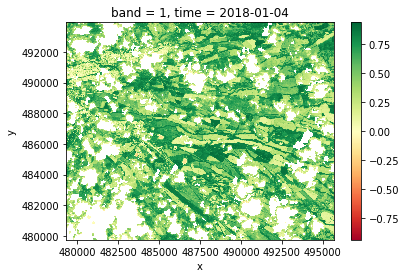

In [48]:
#xdataset.coords['time']
def plot_index(xdataset, band, date_index, mask=True):
    """"""
    #time = datetime.datetime.strptime(date, '%Y-%m-%d')
    xdataset[band].where(xdataset.mask).isel(time=date_index).plot(cmap='RdYlGn')#cmap='gist_gray'
    
plot_index(s2_xds, 'NDVI', 1)

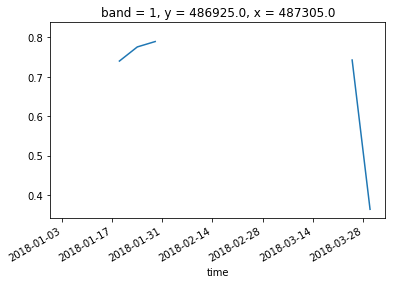

In [49]:
#%matplotlib inline
time_series = s2_xds['NDVI'].where(s2_xds.mask).sel(y=486925, x=487305).sortby('time').plot()

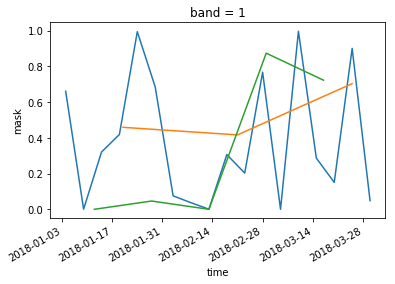

In [75]:
# Calculate percentage of quality pixels
s2_xds.mask.mean(['x', 'y']).sortby('time').plot.line(x='time')
l7_xds.mask.mean(['x', 'y']).sortby('time').plot.line(x='time')
l8_xds.mask.mean(['x', 'y']).sortby('time').plot.line(x='time')

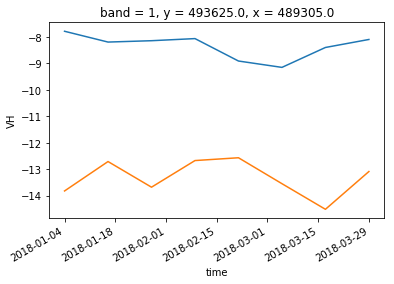

In [74]:
# Plot values para polarization
s1_xds['VV'].isel(x=1000, y=30).sortby('time').plot.line(x='time')
s1_xds['VH'].isel(x=1000, y=30).sortby('time').plot.line(x='time')

In [9]:
## for mosaicing, a possible approach is gdalbuildvrt

## To save xarray objects to disk> da.to_netcdf('/path/to/location/file.nc')

## TODO: check benefits of using chunks e.g. xr.open_rasterio(...chunks = {'x': 5490, 'y': 5490, 'band': 1})

Use xarray register accessors to perform user defined methods. e.g. to report rgb images of eo_stack

In [36]:
import math
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import datetime as dt

@xr.register_dataarray_accessor('eotempa')
class EOTempArray(object):
    
    def __init__(self, xarray_obj):
        self._obj = xarray_obj
        
    def plot_RGB(self, save_file=None):
        
        crs = ccrs.UTM('18N')
        av_dates = self._obj.coords['time'].data.tolist()
        
        plt.figure(figsize=(15,3*math.ceil(len(av_dates)/5.0)))
        try:
            rgb = self._obj.sel(band=['red', 'green', 'blue']).sortby('time')
        except:
            print('The EOTempArray does not contain rgb bands')
            return None
        for ix, date in enumerate(av_dates):
            ap = rgb.isel(time=ix)/10000
            ax = plt.subplot(math.ceil(len(av_dates)/5.0),5,1+ix, projection=crs)
            ap.plot.imshow(rgb='band', transform=crs)
        
        if save_file is not None:
            plt.savefig(save_file, dpi=300)
            
        plt.show()
        
#xr.register_accessor('spec', EOTempArray)

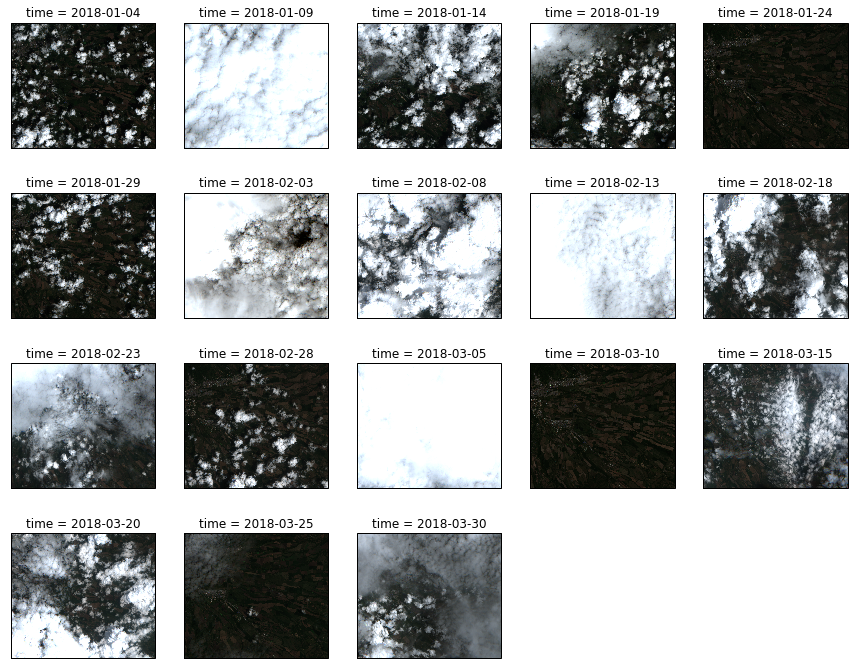

In [37]:
s2_xar.eotempa.plot_RGB()  # calls the EOTempArray.plot_RGB method

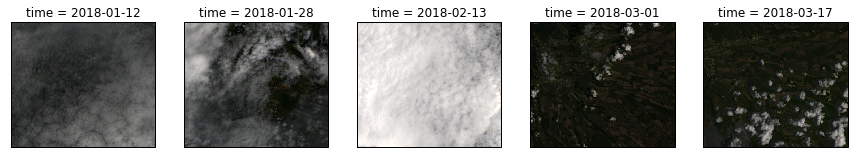

In [38]:
l8_xar.eotempa.plot_RGB()

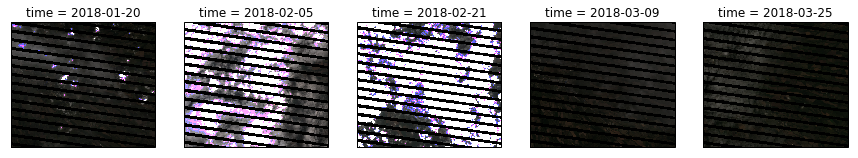

In [39]:
l7_xar.eotempa.plot_RGB()

In [76]:
# Serialization of xarray and xdatabase objects
s1_xar.to_netcdf('/home/azalazar/data/Ibague/pre/stack/s1xar.nc')
s2_xar.to_netcdf('/home/azalazar/data/Ibague/pre/stack/s2xar.nc')
l7_xar.to_netcdf('/home/azalazar/data/Ibague/pre/stack/l7xar.nc')
l8_xar.to_netcdf('/home/azalazar/data/Ibague/pre/stack/l8xar.nc')
s1_xds.to_netcdf('/home/azalazar/data/Ibague/pre/stack/s1xds.nc')
s2_xds.to_netcdf('/home/azalazar/data/Ibague/pre/stack/s2xds.nc')
l7_xds.to_netcdf('/home/azalazar/data/Ibague/pre/stack/l7xds.nc')
l8_xds.to_netcdf('/home/azalazar/data/Ibague/pre/stack/l8xds.nc')